In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import sys
import seaborn as sns

In [6]:
class Error:
    
    def __init__(self, truth, predictions):
        self._truth = truth 
        self._predictions = predictions

    @property
    def truth(self):
        return self._truth

    @property
    def predictions(self):
        return self._predictions
        
    @truth.setter
    def truth(self, value):
        self._truth = value

    @predictions.setter
    def predictions(self, value):
        self._predictions = value
        
    def L1error(self):
        
        if not isinstance(self._truth, list) and \
            not isinstance(self._truth, np.ndarray):
            return abs(self._truth - self._predictions)
        
        return sum([abs(y - yhat) for y, yhat in zip(self._truth, self._predictions)])/len(self._truth)
    
    def L2error(self):

        if not isinstance(self._truth, list) and \
            not isinstance(self._truth, np.ndarray):
            return (self._truth - self._predictions)**2
        
        return sum([(y - yhat)**2 for y, yhat in zip(self._truth, self._predictions)])/len(self._truth)
        
    
    def Linftyerror(self):
        
        if not isinstance(self._truth, list) and \
            not isinstance(self._truth, np.ndarray):
            return abs(self._truth - self._predictions)
        
        return max([abs(y - yhat) for y, yhat in zip(self._truth, self._predictions)])

    def test(self):
                
        return {'Linfty': self.Linftyerror(),
                'L2': self.L2error(),
                'L1': self.L1error()}

In [7]:
error = Error([23, 20], [20, 21])
error.test()

{'Linfty': 3, 'L2': 5.0, 'L1': 2.0}

In [8]:
def laplace_mechanism(oracle_output, 
                      epsilon, 
                      sensitivity):

    '''
    oracle_output: value sent to analyser
    epsilon: privacy budget
    sensitivity: to calibrate the variance for problem. 1 for bin sum.
    '''
    scale = sensitivity/epsilon
    
    if isinstance(oracle_output, np.int64) or isinstance(oracle_output, np.float64) or\
        isinstance(oracle_output, int) or isinstance(oracle_output, float):
        return oracle_output +  np.random.laplace(loc=0.0, scale=scale, size=None)
    
    z = np.zeros(len(oracle_output))
    for i in range(len(oracle_output)):
        z[i] = oracle_output[i] + np.random.laplace(loc=0.0, scale=scale, size=None)
        
    return z 

In [9]:
def sample_and_threshold(population_data, m, tau):

    n = len(population_data)
    sampled_population = []
    for d in population_data:
        if np.random.random() <= m/n:
            sampled_population.append(d)
            
    predictons = pd.Series(Counter(np.sort(sampled_population)))
    assert len(predictons) >= 1
    
    # kill of small guys
    predictons[predictons < tau] = 0 
    
    

# Simple Binary sum problem

In [10]:
# CREATE TRUTH VALUE
n = 10**5
p = 0.5
num_ones = np.random.binomial(n=n, p=p)
num_zeroes = n - num_ones

data = [1]*num_ones + [0]*num_zeroes
np.random.shuffle(data)

# Laplace Mechanism

In [11]:
class LaplaceMechanismBinSum:
    
    def __init__(self, num_trials, truth, num_users):
        self._num_trials = num_trials
        self._truth = sum(truth)
        self._n = num_users
        self._epsilons = np.linspace(0.0001, 0.5, 20)
        self._plotting_data = {k: [] for k in self._epsilons}
        
        
    def do_single_experiment(self):
        
        truth = self._truth
        output = {}

        for epsilon in self._epsilons:

            predicitions = laplace_mechanism(truth, 
                                            epsilon, 
                                            1) 

            error = Error(truth/self._n, predicitions/self._n)
            self._plotting_data[epsilon].append(error.test())
        
    def experiment(self):
        
        for i in range(self._num_trials):
            self.do_single_experiment()
            
        self._plotting_data = {k: pd.DataFrame(v) for k, v in self._plotting_data.items()}
    

Text(0, 0.5, 'Normalised error')

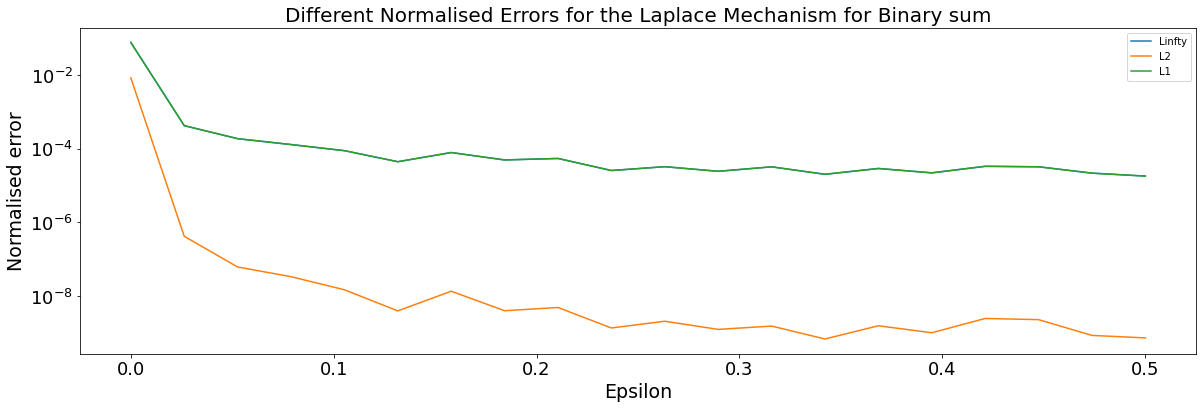

In [12]:
lap = LaplaceMechanismBinSum(20, data, len(data))
lap.experiment()
df = pd.DataFrame({eps: df.mean() for eps, df in lap._plotting_data.items()}).T
ax = df.plot(figsize=(20,6), fontsize=18)
ax.set_yscale('log')
ax.set_title('Different Normalised Errors for the Laplace Mechanism for Binary sum', fontsize=20)
ax.set_xlabel('Epsilon', fontsize=19)
ax.set_ylabel('Normalised error', fontsize=19)

# Randomised Response

In [13]:
# RANDOMISED RESPONSE LOCAL PRIVACY
# Algorithm peseudo code and proofs: https://abiswas3.github.io/differentialprivacy/PrivateMeanEstimation/

def randomised_response(data, gamma):
    
    assert gamma < 1/2
    
    N = len(data)
    k = sum([x if np.random.random() <= 0.5 + gamma else 1 - x for x in data])
    
    return (k - (0.5 - gamma)*N)/(2*gamma)
        
        
            

In [14]:
class RandomisedResponseBinSum:
    
    def __init__(self, num_trials, truth, num_users):
        self._num_trials = num_trials
        self._truth = truth 
        self._n = num_users
        self._epsilons = np.linspace(0.0001, 0.499, 20)
        self._plotting_data = {k: [] for k in self._epsilons}
        
        
    def do_single_experiment(self):
        
        truth = self._truth
        output = {}

        for epsilon in self._epsilons:
            predicitions = randomised_response(truth, 
                                              epsilon) 

            error = Error(sum(truth)/self._n, predicitions/self._n)
            self._plotting_data[epsilon].append(error.test())
        
    def experiment(self):
        
        for i in range(self._num_trials):
            sys.stdout.write("\r")
            sys.stdout.write("{}/{}".format(i+1, self._num_trials))            
            self.do_single_experiment()
            
        self._plotting_data = {k: pd.DataFrame(v) 
                               for k, v in self._plotting_data.items()}
    

In [15]:
rr = RandomisedResponseBinSum(20, data, len(data))
rr.experiment()


20/20

Text(0, 0.5, 'Normalised error')

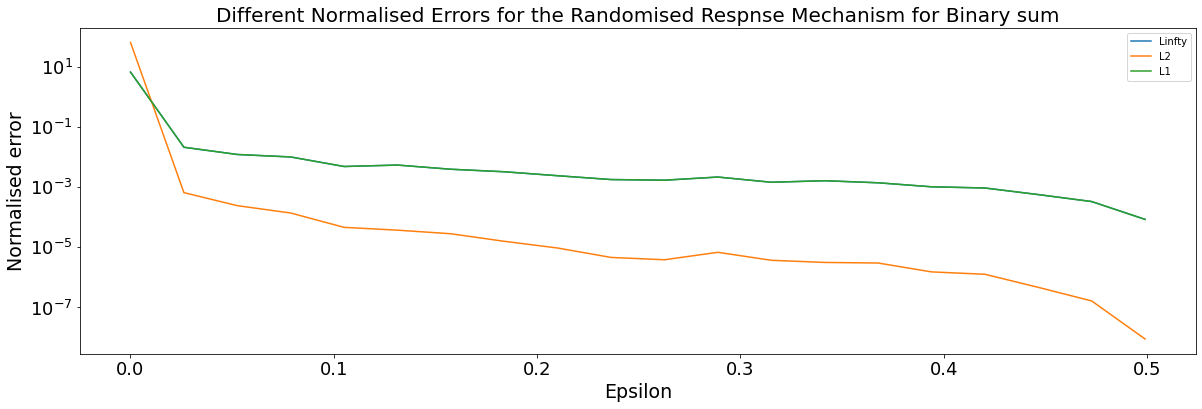

In [16]:
df = pd.DataFrame({eps: df.mean() for eps, df in rr._plotting_data.items()}).T
ax = df.plot(figsize=(20,6), fontsize=18)
ax.set_yscale('log')
ax.set_title('Different Normalised Errors for the Randomised Respnse Mechanism for Binary sum', fontsize=20)
ax.set_xlabel('Epsilon', fontsize=19)
ax.set_ylabel('Normalised error', fontsize=19)

# Shuffle Privacy Cheu

In [17]:
# Shuffle privacy for binary sums - CHEU
# Algorithm peseudo code and proofs: https://abiswas3.github.io/differentialprivacy/ShufflePrivacy/

def cheu(data, epsilon, delta):
    
    n = len(data)
    A = 50/(epsilon**2*n)
    B = np.log(2/delta)
    p = 1 - A*B
    
    # if heads then z is 1 so you send 1 and 0
    # if tails z is 0 and then you send just x
    
    c_star = sum([x + 1 if np.random.random() <= p else x for x in data])/n
    
    return c_star - p
        
        
            

## Not all values of epsilon delta work

Not all values of epsilon and delta work, plugging in different values of $\epsilon$ and $\delta$ we see that only some values lead to $p \in [0,1]$

Text(0.5, 0, 'epsilon')

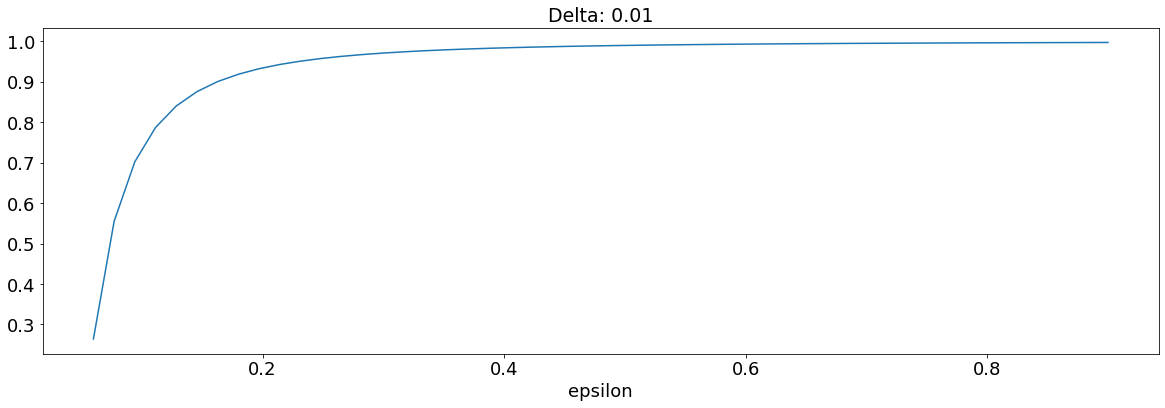

In [18]:

delta = 0.01

# cheu(data, epsilon, delta)
# Need to find a range of epsilons and deltas
temp = {}
for epsilon in np.linspace(0.06, 0.9):    
    A = np.log(2/delta)
    B = 50/(epsilon**2*len(data))
    C = 1 - A*B
    temp[epsilon] = C
    if C < 0 or C > 1: 
        print("Bad epsilon", epsilon)
ax = pd.Series(temp).plot(figsize=(20, 6), fontsize=18)        
ax.set_title("Delta: {}".format(delta), fontsize=19)
ax.set_xlabel('epsilon', fontsize=18)

Text(0.5, 0, 'epsilon')

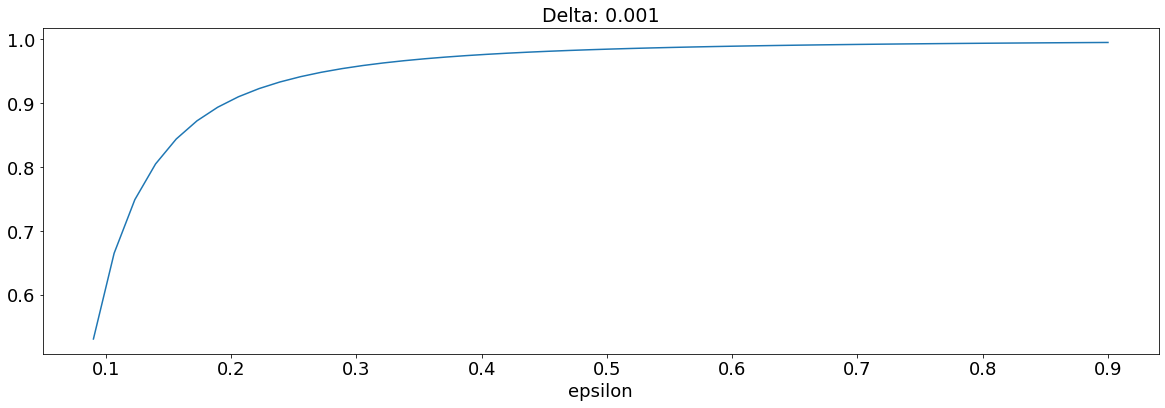

In [19]:
# epsilon = 0.9
delta = 0.001

# cheu(data, epsilon, delta)
# Need to find a range of epsilons and deltas
temp = {}
for epsilon in np.linspace(0.09, 0.9):    
    A = np.log(2/delta)
    B = 50/(epsilon**2*len(data))
    C = 1 - A*B
    temp[epsilon] = C
    if C < 0 or C > 1: 
        print("Bad epsilon", epsilon)
ax = pd.Series(temp).plot(figsize=(20, 6), fontsize=18)        
ax.set_title("Delta: {}".format(delta), fontsize=19)
ax.set_xlabel('epsilon', fontsize=18)

Text(0.5, 0, 'epsilon')

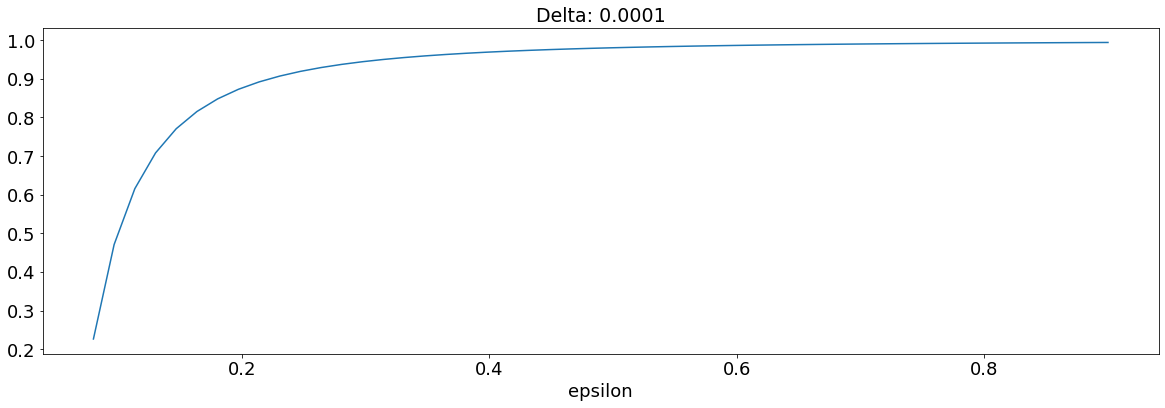

In [20]:
# epsilon = 0.9
delta = 0.0001

# cheu(data, epsilon, delta)
# Need to find a range of epsilons and deltas
temp = {}
for epsilon in np.linspace(0.08, 0.9):    
    A = np.log(2/delta)
    B = 50/(epsilon**2*len(data))
    C = 1 - A*B
    temp[epsilon] = C
    if C < 0 or C > 1: 
        print("Bad epsilon", epsilon)
ax = pd.Series(temp).plot(figsize=(20, 6), fontsize=18)        
ax.set_title("Delta: {}".format(delta), fontsize=19)
ax.set_xlabel('epsilon', fontsize=18)

In [23]:
class CheuBinSum:
    
    def __init__(self, num_trials, truth, num_users, delta=0.001):
        self._num_trials = num_trials
        self._truth = truth 
        self._n = num_users
        self._epsilons = np.linspace(0.09, 0.9)
        self._delta = delta
        self._plotting_data = {k: [] for k in self._epsilons}
        
        
    def do_single_experiment(self):
        
        truth = self._truth
        output = {}

        for epsilon in self._epsilons:
            predictions = cheu(truth, epsilon, self._delta)
            error = Error(sum(truth)/self._n, predictions)
            self._plotting_data[epsilon].append(error.test())
        
    def experiment(self):
        
        for i in range(self._num_trials):
            sys.stdout.write("\r")
            sys.stdout.write("{}/{}".format(i+1, self._num_trials))            
            self.do_single_experiment()
            
        self._plotting_data = {k: pd.DataFrame(v) 
                               for k, v in self._plotting_data.items()}
    

In [24]:
cheuExp = CheuBinSum(20, data, len(data), delta=0.001)
cheuExp.experiment()


20/20

Text(0, 0.5, 'Normalised error')

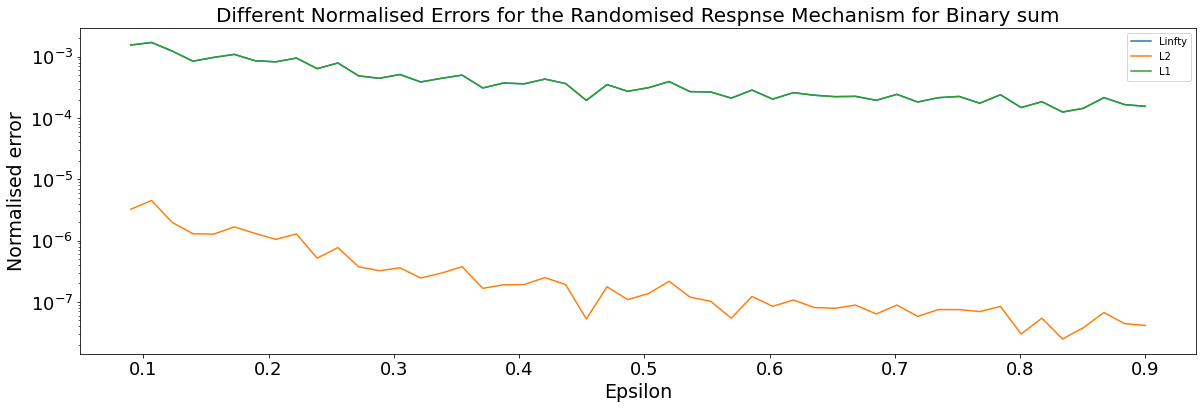

In [25]:
df = pd.DataFrame({eps: df.mean() for eps, df in cheuExp._plotting_data.items()}).T
ax = df.plot(figsize=(20,6), fontsize=18)
ax.set_yscale('log')
ax.set_title('Different Normalised Errors for the Randomised Respnse Mechanism for Binary sum', fontsize=20)
ax.set_xlabel('Epsilon', fontsize=19)
ax.set_ylabel('Normalised error', fontsize=19)

In [30]:
# Grahams work

In [38]:
def sample_and_threshold(data, m, tau):
    
    n = len(data)
    # NAIVE implementation
    arr = []
    for d in data:
        if np.random.random() <= m/n:
            arr.append(d)
    
    # THRESHOLD
    predictions = pd.Series(Counter(np.sort(arr)))
    predictions[predictions < tau] = 0 
            
    print(predictions)
    return predictions.sum()/

In [39]:
m = 1000
sample_and_threshold(data, m, n//m)



0    512
1    480
dtype: int64


0.00992

In [40]:
# when is it not possible for Shuffle to provide privacy

In [41]:
def minimum_value_of_n(epsilon, delta):
    
    return (100/epsilon**2)*np.log(2/delta)

def value_for_m(epsilon, delta):
    return (100/epsilon**2)*np.log(2/delta)

Text(0.5, 15.0, 'Delta')

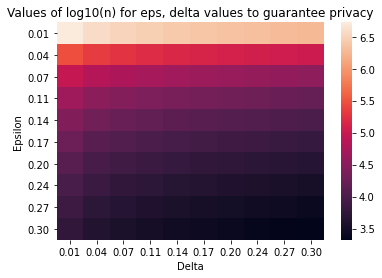

In [69]:
epsilons = np.linspace(0.01, 0.3, 10)
deltas = np.linspace(0.01, 0.3, 10)
chart = np.zeros((len(epsilons), len(deltas)))
for i, epsilon in enumerate(epsilons):
    for j, delta in enumerate(deltas):
        chart[i,j] = np.log10(minimum_value_of_n(epsilon, delta))
        
i_eps = ["{:.2f}".format(i) for i in epsilons]
i_deltas = ["{:.2f}".format(i) for i in deltas]
df = pd.DataFrame(chart, index=i_eps, columns=i_deltas)
ax = sns.heatmap(df, annot=False)
ax.set_title('Values of log10(n) for eps, delta values to guarantee privacy')
ax.set_ylabel('Epsilon')
ax.set_xlabel('Delta')        

Text(0.5, 15.0, 'Delta')

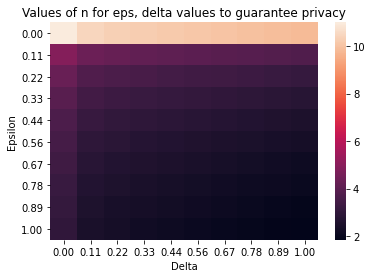

In [63]:
epsilons = np.linspace(0.01, 0.3, 10)
deltas = np.linspace(0.01, 0.3, 10)
chart = np.zeros((len(epsilons), len(deltas)))
for i, epsilon in enumerate(epsilons):
    for j, delta in enumerate(deltas):
        chart[i,j] = np.log10(minimum_value_of_n(epsilon, delta))
        
i_eps = ["{:.2f}".format(i) for i in epsilons]
i_deltas = ["{:.2f}".format(i) for i in deltas]
df = pd.DataFrame(chart, index=i_eps, columns=i_deltas)
ax = sns.heatmap(df, annot=False)
ax.set_title('Values of log10(n) for eps, delta values to guarantee privacy')
ax.set_ylabel('Epsilon')
ax.set_xlabel('Delta')        

In [59]:
chart

array([[10.99578816, 10.46083353, 10.34180528, 10.25323123, 10.17723409,
        10.10749958, 10.04082469,  9.97517117,  9.90897679,  9.84082546],
       [ 4.90357859,  4.36862396,  4.2495957 ,  4.16102166,  4.08502452,
         4.01529   ,  3.94861511,  3.8829616 ,  3.81676721,  3.74861589],
       [ 4.30190923,  3.76695461,  3.64792635,  3.55935231,  3.48335517,
         3.41362065,  3.34694576,  3.28129225,  3.21509786,  3.14694654],
       [ 3.94985697,  3.41490234,  3.29587408,  3.20730004,  3.1313029 ,
         3.06156839,  2.9948935 ,  2.92923998,  2.8630456 ,  2.79489427],
       [ 3.70004463,  3.16509   ,  3.04606174,  2.9574877 ,  2.88149056,
         2.81175605,  2.74508116,  2.67942764,  2.61323326,  2.54508193],
       [ 3.50626369,  2.97130906,  2.8522808 ,  2.76370676,  2.68770962,
         2.6179751 ,  2.55130021,  2.4856467 ,  2.41945231,  2.35130099],
       [ 3.34792725,  2.81297262,  2.69394436,  2.60537032,  2.52937318,
         2.45963867,  2.39296378,  2.32731026

In [52]:
minimum_value_of_n(0.9, 0.9)

98.58119706392242